In [9]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [7]:
!pip install torchvision

In [15]:
data_dir = 'A:/external_data/dataA'

In [21]:
os.path.join(data_dir,'CameraRGB')

'A:/external_data/dataA\\CameraRGB'

In [69]:
class LyftUdacity(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = os.path.join(img_dir,'CameraRGB')
        seg_paths = os.path.join(img_dir,'CameraSeg')
        self.images,self.masks = [],[]
        for i,img in enumerate(os.listdir(image_paths)):
            # imgs = os.listdir(i)
            self.images.append(os.path.join(image_paths,img))
        for i,img in enumerate(os.listdir(seg_paths)):
            # masks = os.listdir(i)
            self.masks.append(os.path.join(seg_paths,img))
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        print('mask.shape',mask.shape)
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            print('mask.shape',mask.shape)
            mask = torch.max(mask,dim=2)[0]
            print('mask.shape',mask.shape)
        return img,mask

In [11]:
def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = LyftUdacity(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch

In [70]:
data = LyftUdacity(data_dir,transform = t1)
print(data.__getitem__(10)[0].shape)
print(data.__getitem__(10)[1].shape)

mask.shape (600, 800, 3)
mask.shape torch.Size([160, 240, 3])
mask.shape torch.Size([160, 240])
torch.Size([3, 160, 240])
mask.shape (600, 800, 3)
mask.shape torch.Size([160, 240, 3])
mask.shape torch.Size([160, 240])
torch.Size([160, 240])


In [62]:
train_batch

In [12]:
t1 = A.Compose([
    A.Resize(160,240),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [77]:
train_batch,test_batch = get_images(data_dir,transform =t1,batch_size=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


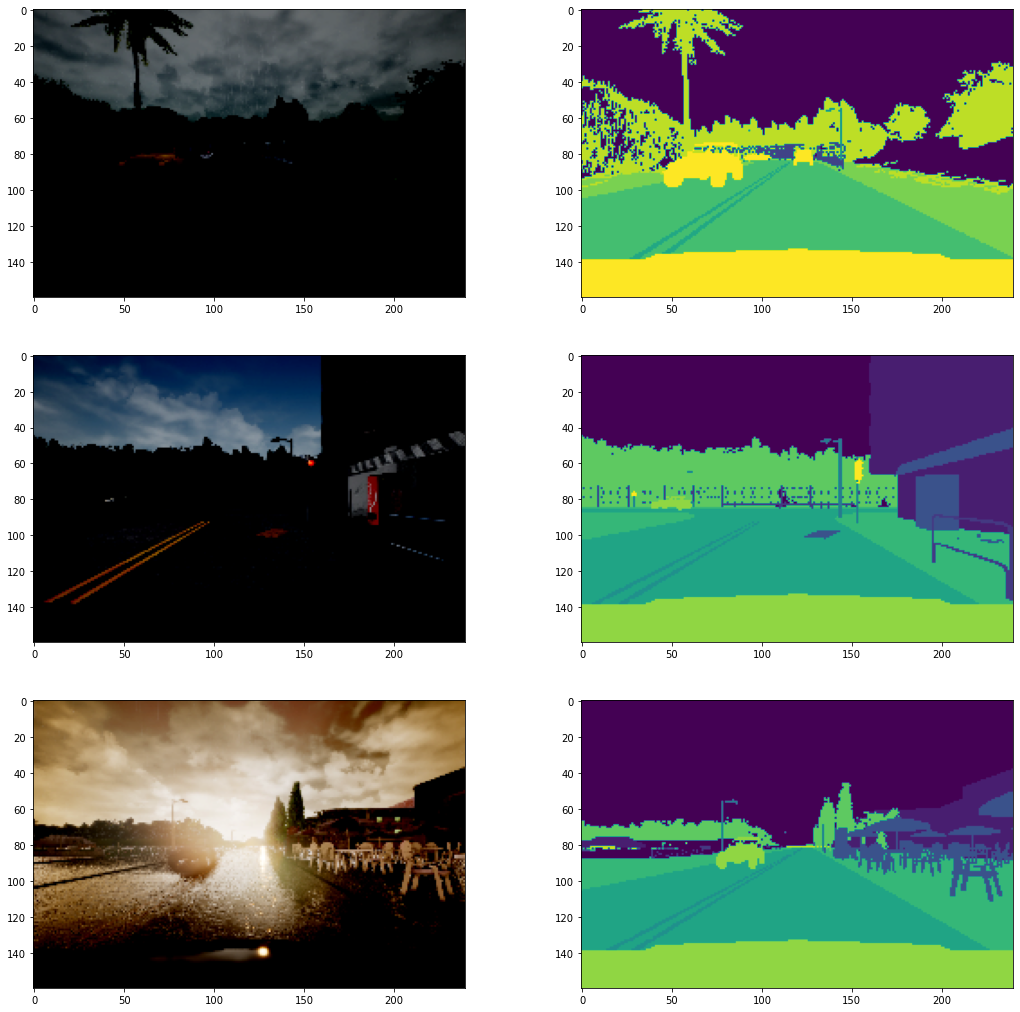

In [24]:
for img,mask in train_batch:
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [25]:
pip install torchsummary 

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
Note: you may need to restart the kernel to use updated packages.


In [26]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)    

In [27]:
class unet_model(nn.Module):
    def __init__(self,out_channels=23,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [40]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = unet_model().to(DEVICE)
from torchsummary import summary
summary(model, (3, 160,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 240]           1,728
       BatchNorm2d-2         [-1, 64, 160, 240]             128
              ReLU-3         [-1, 64, 160, 240]               0
            Conv2d-4         [-1, 64, 160, 240]          36,864
       BatchNorm2d-5         [-1, 64, 160, 240]             128
              ReLU-6         [-1, 64, 160, 240]               0
    encoding_block-7         [-1, 64, 160, 240]               0
         MaxPool2d-8          [-1, 64, 80, 120]               0
            Conv2d-9         [-1, 128, 80, 120]          73,728
      BatchNorm2d-10         [-1, 128, 80, 120]             256
             ReLU-11         [-1, 128, 80, 120]               0
           Conv2d-12         [-1, 128, 80, 120]         147,456
      BatchNorm2d-13         [-1, 128, 80, 120]             256
             ReLU-14         [-1, 128, 

In [29]:
LEARNING_RATE = 1e-4
num_epochs = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

C:\Users\y.sobolev\Anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [42]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

In [76]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            print(data.shape,type(data),data.dtype)
            print(data)
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

torch.Size([8, 3, 160, 240]) <class 'torch.Tensor'> torch.float32
tensor([[[[-0.9529, -0.8980, -0.8980,  ..., -0.4667, -0.4745, -0.4588],
          [-0.8431, -0.8667, -0.8353,  ..., -0.4902, -0.6627, -0.4902],
          [-0.8745, -0.9922, -0.8980,  ..., -0.9294, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.2392, -0.2392, -0.2392],
          [-0.7569, -1.0000, -0.9294,  ..., -0.2549, -0.5137, -0.2549],
          [-0.8902, -1.0000, -1.0000,  ..., -0.9294, -0.9843, -0.9843],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000

  1%|▋                                                                     | 1/100 [00:04<08:03,  4.88s/it, loss=0.263]

torch.Size([8, 3, 160, 240]) <class 'torch.Tensor'> torch.float32
tensor([[[[-0.4588, -0.4745, -0.4824,  ..., -0.9922, -1.0000, -1.0000],
          [-0.4431, -0.4431, -0.4980,  ..., -1.0000, -1.0000, -1.0000],
          [-0.4980, -0.5216, -0.8902,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-0.2392, -0.2392, -0.2314,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2314, -0.2314, -0.2549,  ..., -1.0000, -1.0000, -1.0000],
          [-0.2784, -0.2784, -0.9608,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.0588,  0.0667,  0.0824

  2%|█▍                                                                    | 2/100 [00:09<08:00,  4.90s/it, loss=0.243]

torch.Size([8, 3, 160, 240]) <class 'torch.Tensor'> torch.float32
tensor([[[[-0.1059, -0.1059, -0.1059,  ..., -0.4745, -0.4353, -0.3569],
          [-0.0824, -0.0745, -0.0667,  ..., -0.7490, -0.9059, -0.6000],
          [-0.0510, -0.0588, -0.0588,  ..., -0.8902, -0.9529, -0.9765],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.0353,  0.0353,  0.0353,  ..., -0.3176, -0.3176, -0.1843],
          [ 0.0431,  0.0510,  0.0588,  ..., -0.6863, -0.8431, -0.4510],
          [ 0.0745,  0.0667,  0.0667,  ..., -0.8275, -0.8902, -0.8902],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[ 0.1686,  0.1686,  0.1686

  2%|█▍                                                                    | 2/100 [00:10<08:55,  5.46s/it, loss=0.243]


KeyboardInterrupt: 

In [41]:
root_model='A:\external_data'
# torch.save(model, root_model + '/_best_model_loss.pth')
model = torch.load(root_model + '/_best_model_loss.pth ', map_location=DEVICE) # Если нужно доучить модель

In [34]:
targets.shape

torch.Size([8, 160, 240])

In [43]:
check_accuracy(train_batch, model)

Got 29148130/30720000 with acc 94.88
Dice score: 8.246169090270996


In [44]:
check_accuracy(test_batch, model)

Got 7306922/7680000 with acc 95.14
Dice score: 8.241647720336914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


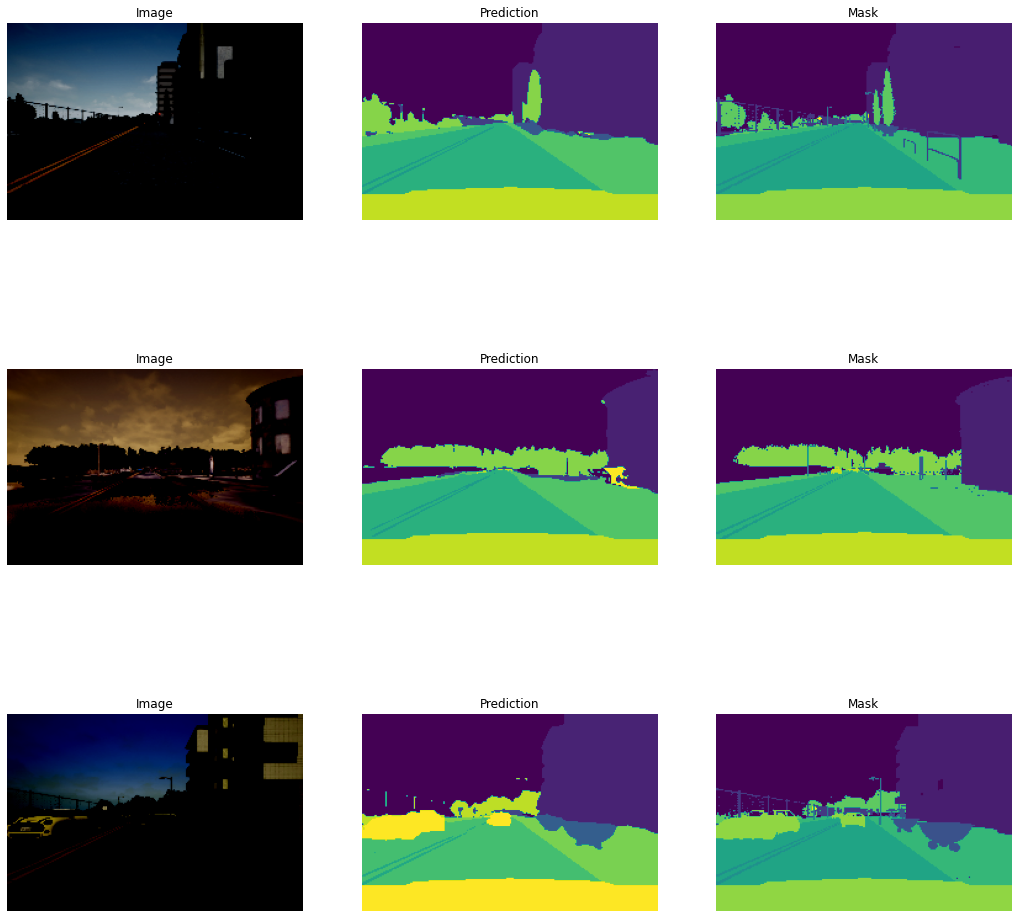

In [45]:
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break

In [52]:
img = np.array(Image.open("A:/external_data/dataA/CameraRGB/02_00_000.png"))
mask = np.array(Image.open("A:/external_data/dataA/CameraSeg/02_00_000.png"))
print(img.shape,mask.shape)

(600, 800, 3) (600, 800, 3)


In [50]:
np.unique(mask)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 12], dtype=uint8)

In [53]:
np.unique(mask)

array([ 0,  1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12], dtype=uint8)

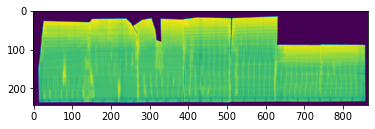

In [65]:
img=np.load("A:/multiclass_data/train/090120200033-60.npy")
mask=np.load("A:/multiclass_data/train_mask/020120190013-6401-mask.npy")
plt.imshow(img)
plt.show()

In [67]:
img.shape

(243, 865)

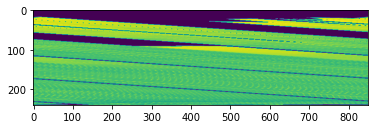

In [68]:
a=np.resize(img,(240,850))
plt.imshow(a)
plt.show()